# Example reduction

In [1]:
import sys
import os
sys.path.append(os.path.expanduser('~/git/LiquidsReflectometer/reduction'))

import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

#%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

In [2]:
import mantid
import mantid.simpleapi as api
mantid.kernel.config.setLogLevel(3)

ConfigService-[Information] Unable to locate directory at: /etc/mantid/instrument
ConfigService-[Information] This is Mantid version 6.3.0 revision g3629346a7f5
ConfigService-[Information] running on jupyter-node01.sns.gov starting 2022-12-21T14:43Z
ConfigService-[Information] Properties file(s) loaded: /usr/local/anaconda/envs/sans/bin/Mantid.properties, /etc/mantid.local.properties, /SNS/users/m2d/.mantid/Mantid.user.properties
ConfigService-[Information] Unable to locate directory at: /etc/mantid/instrument
FrameworkManager-[Notice] Welcome to Mantid 6.3.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.3
FrameworkManager-[Information] Version check disabled.
GitHubApiHelper-[Information] Making unauthenticated calls to GitHub
GitHubApiHelper-[Information] Making unauthenticated calls to GitHub
DownloadInstrument-[Notice] All instrument definitions up to date
ConfigService-[Error] loggin

In [3]:
print(mantid.__version__)
print(sys.version)

6.3.0
3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]


In [4]:
import importlib
from lr_reduction import event_reduction
from lr_reduction import template


# Reduction


198409
wl=15; ths=0.610382; offset=0.01

198410
wl=12.386; ths=0.610058; offset=0.01

198411
wl=9.74; ths=0.610058; offset=0.01

198412
wl=7.043; ths=0.609896; offset=0.01

198413
wl=4.25; ths=0.609733; offset=0.01

198414
wl=4.25; ths=1.19271; offset=0.01

198415
wl=4.25; ths=2.35284; offset=0.01

198416
wl=4.25; ths=4.64906; offset=0.01


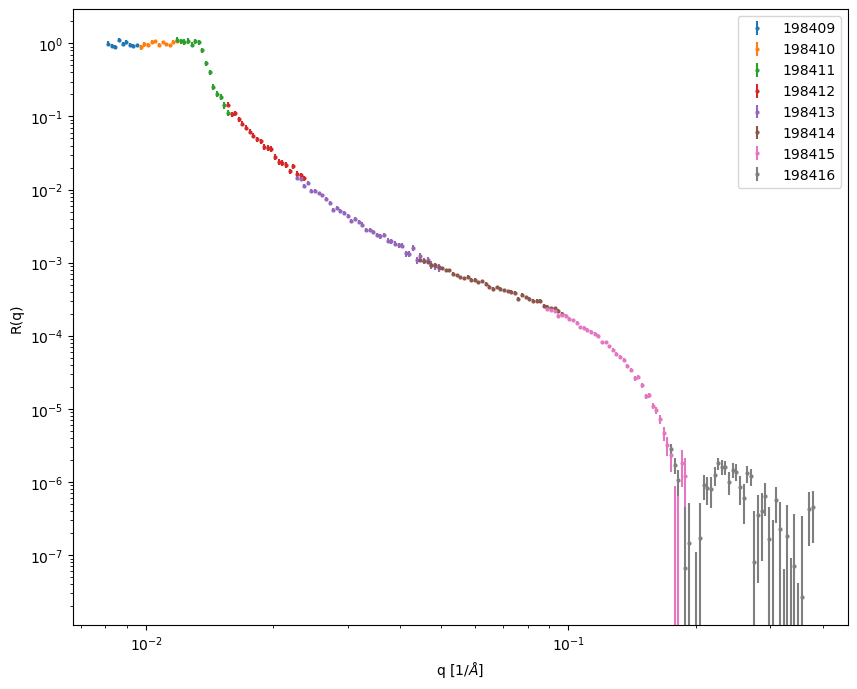

Q resolution = 0.02785205863936946


In [5]:
importlib.reload(template)
importlib.reload(event_reduction)

data_dir = os.path.expanduser('~/git/LiquidsReflectometer/reduction/data')
template_path = os.path.join(data_dir, 'template.xml')

#qz_mid, refl, d_refl = template.process_from_template(run_number, template_path)
pre_cut = 1
post_cut = 1

qz_all = []
refl_all = []
d_refl_all = []

first_run = None

fig, ax = plt.subplots(figsize=(10,8))

first_run = None
resolution = 0.028


for run_number in range(198409, 198417):

    print('\n%s' % run_number)
    ws_sc = api.Load("REF_L_%s" % run_number)
    qz_mid, refl, d_refl = template.process_from_template_ws(ws_sc, template_path)

    if first_run is None:
        first_run = run_number
        resolution = event_reduction.compute_resolution(ws_sc)

    idx = np.fabs(refl) > 0
    qz_mid = qz_mid[idx][pre_cut:-post_cut]
    refl = refl[idx][pre_cut:-post_cut]
    d_refl = d_refl[idx][pre_cut:-post_cut]
    
    plt.errorbar(qz_mid, refl, yerr=d_refl, markersize=4, marker='.', linestyle='', label=run_number)
 
    for i in range(len(qz_mid)-1, -1, -1):
        qz_all.append(qz_mid[i])
        refl_all.append(refl[i])
        d_refl_all.append(d_refl[i])

qz_all = np.asarray(qz_all)
refl_all = np.asarray(refl_all)
d_refl_all = np.asarray(d_refl_all)
idx = np.argsort(qz_all)

qz_all = np.take_along_axis(qz_all, idx, axis=None)
refl_all = np.take_along_axis(refl_all, idx, axis=None)
d_refl_all = np.take_along_axis(d_refl_all, idx, axis=None)


plt.legend()
plt.xlabel('q [$1/\AA$]')
plt.ylabel('R(q)')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()



print("Q resolution = %s" % resolution)

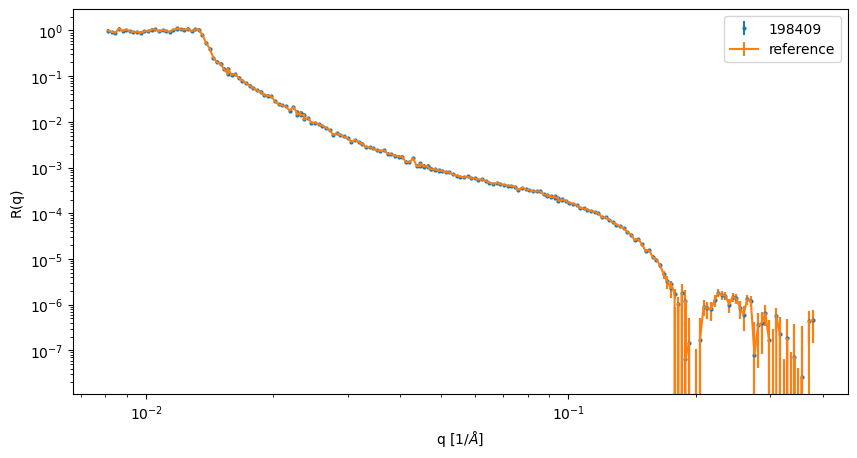

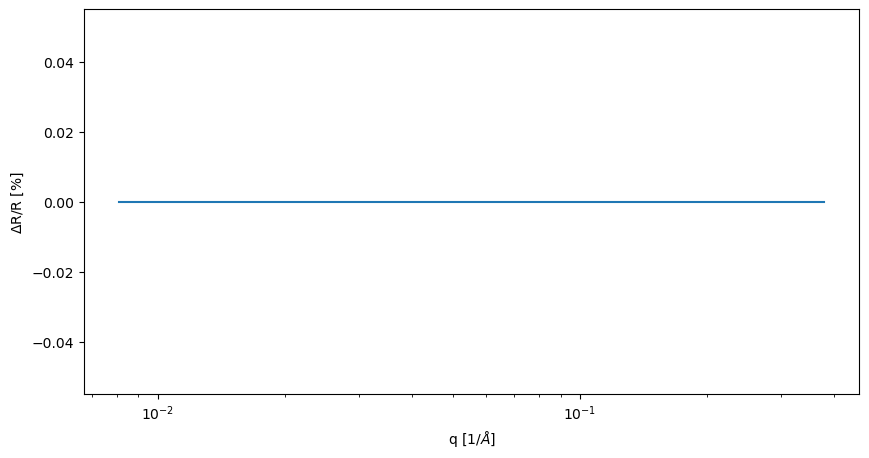

Writing file: /SNS/users/m2d/git/LiquidsReflectometer/reduction/data/../r198409.txt


In [6]:
reduced_path = os.path.join(data_dir, 'reference_rq.txt')

if os.path.isfile(reduced_path):
    _data = np.loadtxt(reduced_path).T

fig, ax = plt.subplots(figsize=(10,5))
plt.errorbar(qz_all, refl_all, yerr=d_refl_all, markersize=4, marker='.', linestyle='', label=first_run)
plt.errorbar(_data[0], _data[1], yerr=_data[2], markersize=4, marker='', linestyle='-', label='reference')

plt.legend()
plt.xlabel('q [$1/\AA$]')
plt.ylabel('R(q)')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

if len(_data[1])==len(refl_all):
    delta = np.fabs(_data[1]-refl_all)/refl_all*100
    fig, ax = plt.subplots(figsize=(10,5))
    plt.plot(qz_all, delta)

    plt.xlabel('q [$1/\AA$]')
    plt.ylabel('$\Delta$R/R [%]')
    ax.set_yscale('linear')
    ax.set_xscale('log')
    plt.show()

dq = qz_all * resolution
output_file = os.path.join(data_dir, '..', "r%s.txt" % first_run)
np.savetxt(output_file, np.asarray([qz_all, refl_all, d_refl_all, dq]).T)
print("Writing file: %s" % output_file)
